# **Dimensionality Reduction: PCA and t-SNE on the Diamond Dataset**

## This notebook applies::
1. **Principal Component Analysis (PCA)** (linear method)
2. **t-SNE** (nonlinear method)

Steps:
1. Preprocess the dataset (digitize categorical features)
2. Standardize numerical features
3. Apply PCA and interpret components
4. Apply t-SNE for 2D visualization

Dataset: Diamond.csv (Chu, 2001) — 308 observations, 5 variables

## **1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## **2. Load and Inspect the Dataset**

In [2]:
df = pd.read_csv("Diamond.csv")
print("Dataset shape:", df.shape)
df.head()

# Interpretation:
# The dataset contains 308 diamond records with 5 columns:
# - Numerical: `carat`, `price`
# - Categorical: `colour`, `clarity`, `certification`
# Since PCA and t-SNE require **numerical input**, we must first digitize the categorical features.

Dataset shape: (308, 5)


,carat,colour,clarity,certification,price
0,0.30,D,VS2,GIA,1302
1,0.30,E,VS1,GIA,1510
2,0.30,G,VVS1,GIA,1510
3,0.30,G,VS1,GIA,1260
4,0.31,D,VS1,GIA,1641


## **3. Digitize Categorical Features**

In [3]:
df_encoded = pd.get_dummies(
    df,
    columns=['colour', 'clarity', 'certification'],
    prefix=['colour', 'clarity', 'certification']
)

print("Shape after one-hot encoding:", df_encoded.shape)
print("Total features (m):", df_encoded.shape[1])

# Interpretation:
# One-hot encoding converts each category into a binary (0/1) column.
# For example, `colour_D`, `clarity_IF`, `certification_GIA`, etc.
# This ensures no false ordinal relationship is introduced.
# The total number of features is now m = 2 (original numerical) + 6 (colour) + 5 (clarity) + 3 (certification) = 16.

Shape after one-hot encoding: (308, 16)
Total features (m): 16


## **4. Standardize the Data**

In [4]:
# PCA is sensitive to scale.
# Features have different units of measurement.
# When applying formal computational algorithms, features with large absolute values will contribute more and «distort» the result.

X = df_encoded.values  # All features are now numerical
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [5]:
# Convert back to DataFrame for clarity (optional)
X_std_df = pd.DataFrame(X_std, columns=df_encoded.columns)

print("Standardized data (mean ≈ 0, std ≈ 1):")
print("Mean per feature:", np.round(X_std_df.mean(), 2).values[:5], "...")
print("Std per feature:", np.round(X_std_df.std(), 2).values[:5], "...")

# Interpretation:
# Standardization centers each variable (mean = 0) and scales it (std = 1).
# This ensures that `carat` (range ~0.2–1.1) and `price` (range ~600–16000) contribute equally to PCA.
# Without standardization, `price` would dominate due to its larger scale.

Standardized data (mean ≈ 0, std ≈ 1):
Mean per feature: [ 0.  0. -0.  0.  0.] ...
Std per feature: [1. 1. 1. 1. 1.] ...


## **5. Apply Principal Component Analysis (PCA)**

In [6]:
# - PCA constructs new uncorrelated variables (principal components)
# - They are linear combinations of standardized original variables
# - Ordered by decreasing variance

pca = PCA()
PC = pca.fit_transform(X_std)  # PC is n × m

In [7]:
# Explained variance
explained_var = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_

print("Total variance (should equal m = 16):", np.sum(explained_var))
print("Variance of first 5 PCs:", np.round(explained_var[:5], 2))

Total variance (should equal m = 16): 16.05211726384365
Variance of first 5 PCs: [3.03 2.07 1.47 1.38 1.27]


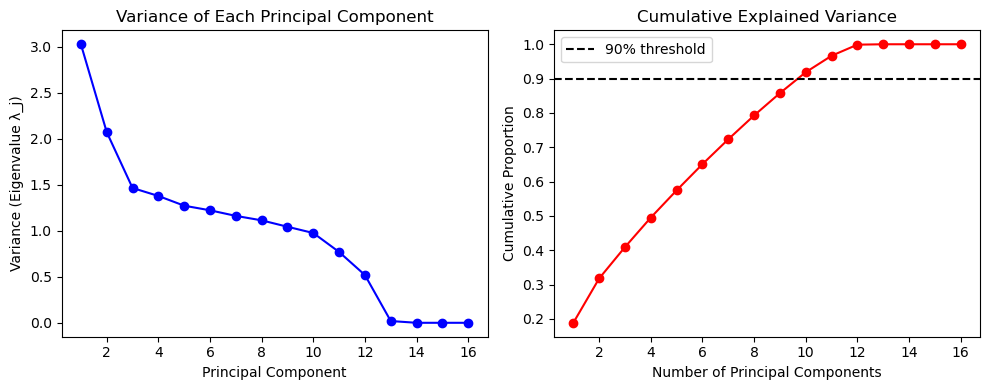

In [8]:
# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_var)+1), explained_var, 'bo-')
plt.title('Variance of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance (Eigenvalue λ_j)')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var_ratio), 'ro-')
plt.axhline(y=0.9, color='k', linestyle='--', label='90% threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretation:
# - Each PC’s variance = eigenvalue λ_j of the correlation matrix.
# - The cumulative variance plot helps decide how many PCs to keep.
# - We select the smallest d such that cumulative variance ≥ 90%.
# - In this dataset, the first 2–3 PCs likely capture most of the information due to correlations among dummy variables.

In [9]:
# Determine number of components for 90% variance
cumsum_var = np.cumsum(explained_var_ratio)
d_90 = np.argmax(cumsum_var >= 0.9) + 1
print(f"\nNumber of PCs needed for ≥90% variance: {d_90}")



Number of PCs needed for ≥90% variance: 10


## **6. Examine PCA Loadings (Optional but Informative)**

In [10]:
# Loadings show how original features contribute to each PC
loadings = pca.components_.T  # Shape: (m, m)
loading_df = pd.DataFrame(
    loadings[:, :5],  # First 5 PCs
    index=df_encoded.columns,
    columns=[f'PC{i+1}' for i in range(5)]
)

print("\nLoadings for first 2 PCs (absolute values, top 5 features):")
print(loading_df[['PC1', 'PC2']].abs().sum(axis=1).sort_values(ascending=False).head())

# Interpretation:
# - A high absolute loading means the original feature strongly influences that PC.
# - Since we used one-hot encoding, categories from the same variable are negatively correlated,
#   so PCs often represent contrasts (e.g., GIA vs. HRD, D vs. I).


Loadings for first 2 PCs (absolute values, top 5 features):
certification_GIA    0.766228
certification_HRD    0.727449
carat                0.664950
price                0.645941
certification_IGI    0.614599
dtype: float64


## **7. Apply t-SNE for Nonlinear Dimensionality Reduction**

In [11]:
# - t-SNE preserves local structure (neighborhoods)
# - It is ideal for visualization (d=2 or 3)
# - It uses probabilistic similarity and KL divergence

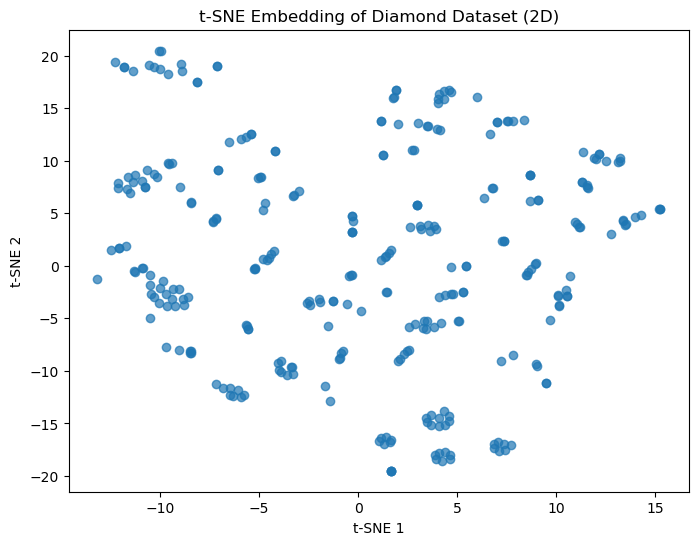

In [13]:
# We apply t-SNE to the **standardized data** (X_std)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_std)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('t-SNE Embedding of Diamond Dataset (2D)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Interpretation:
# - t-SNE creates a 2D map where **similar diamonds are placed close together**.
# - Unlike PCA, it does **not preserve global structure or variance**—it focuses on local neighborhoods.
# - The **perplexity** parameter (Slide 23) balances attention to local vs. global structure (typically 5–50).
# - t-SNE is **stochastic**: running it multiple times may yield different layouts.


## **8. Compare PCA and t-SNE Visualizations**

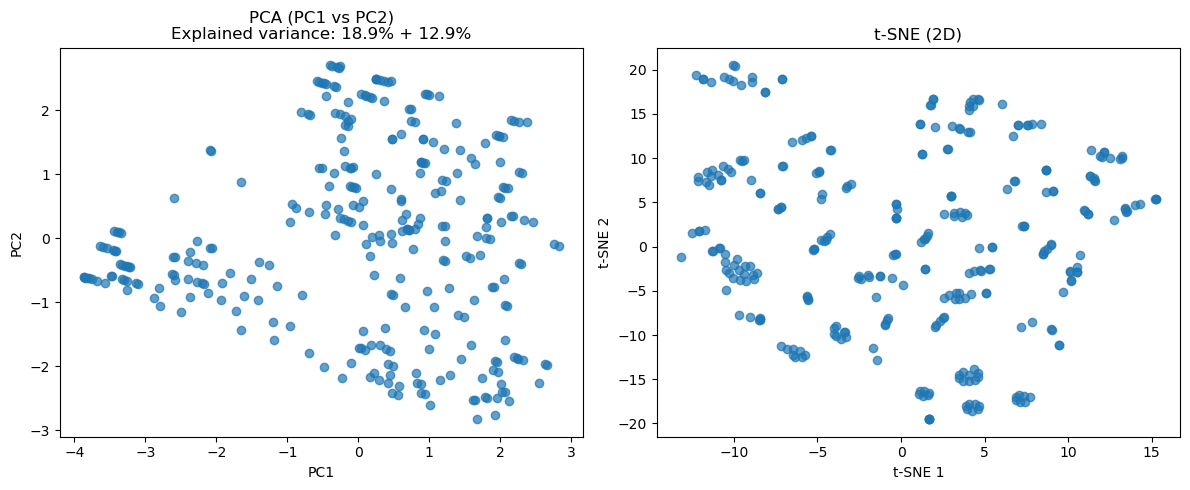

In [14]:
# Visualize first 2 PCs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(PC[:, 0], PC[:, 1], alpha=0.7)
plt.title(f'PCA (PC1 vs PC2)\nExplained variance: {explained_var_ratio[0]:.1%} + {explained_var_ratio[1]:.1%}')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('t-SNE (2D)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Interpretation:
# - PCA is linear, deterministic, and preserves global variance.
# - t-SNE is nonlinear, stochastic, and preserves local similarities.
# - Use PCA for dimensionality reduction before modeling (e.g., regression).
# - Use t-SNE for exploratory visualization and cluster detection.

## **9. Summary**

- Categorical features were digitized using **one-hot encoding** to enable numerical analysis.
- Data was **standardized** to ensure fair contribution of all features to PCA.
- **PCA** identified a small number of components capturing >90% of total variance.
- **t-SNE** provided a nonlinear 2D map emphasizing local structure.
- These methods are complementary: PCA for compression, t-SNE for visualization.